# Introduction

Skin cancer is one of the most common types of cancer worldwide, and early detection is vital for effective treatment. In this project, we use the HAM10000 dataset, which contains dermatoscopic images of various skin diseases, to train a deep learning model for automated classification. We employ the EfficientNetB0 architecture, known for its balance between accuracy and efficiency. The images were resized to 224x224 pixels and directly fed into the model without any additional preprocessing, data augmentation, or label encoding.

## Key Steps in This Project:

1. Used the HAM10000 dataset with 7 skin disease categories
2. Resized images to 224x224 pixels
3. Built a model using EfficientNetB0 with pretrained ImageNet weights
4. Trained the model for 10 epochs and evaluated its performance on validation and test data
5. Visualized training, validation, and test accuracy/loss

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading Data

Loads the metadata CSV file associated with the HAM10000 dataset and displays the first few rows to understand the structure and contents.

In [2]:
import pandas as pd

metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Merging Image Files

This code merges all image files from two separate folders of the HAM10000 dataset into one folder (/kaggle/working/all_images) to make loading easier for model training.

In [3]:
import os
import shutil

# Create destination folder
os.makedirs("/kaggle/working/all_images", exist_ok=True)

# Source folders
part1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
part2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
dest = "/kaggle/working/all_images"

# Copy both parts
for part in [part1, part2]:
    for file in os.listdir(part):
        shutil.copy(os.path.join(part, file), dest)

### Splitting Dataset into Train, Validation, and Test Sets

This block splits the data into train (80%), validation (10%), and test (10%) sets based on skin disease labels (dx), then creates folders for each class under these sets and copies the corresponding image files into them. This prepares the dataset in a structured format for training the CNN model.

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Add a column for file paths
metadata['path'] = metadata['image_id'] + '.jpg'

# Train/Val/Test split
train_df, temp_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

# Create folders
base_dir = "/kaggle/working/ham10000_data"
for split, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    for label in df['dx'].unique():
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)
    for _, row in df.iterrows():
        src = os.path.join(dest, row['path'])
        dst = os.path.join(base_dir, split, row['dx'], row['path'])
        shutil.copy(src, dst)

### Loading Image Datasets

This code loads the train, validation, and test image datasets from their respective folders using TensorFlow’s image_dataset_from_directory, resizing all images to 224x224 and batching them with size 32.

In [5]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + "/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + "/val",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + "/test",
    image_size=img_size,
    batch_size=batch_size
)

Found 8012 files belonging to 7 classes.
Found 1001 files belonging to 7 classes.
Found 1002 files belonging to 7 classes.


### Building & Training the EfficientNetB0 Model CNN

It loads a pre-trained EfficientNetB0 model (without the top layer), freezes its weights, and adds custom dense layers for classification into 7 classes. The model is compiled with Adam optimizer, using loss is sparse_categorical_crossentropy and trained for 10 epochs using the training and validation datasets.

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 skin lesion classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 66s 168ms/step - accuracy: 0.6683 - loss: 0.9856 - val_accuracy: 0.7143 - val_loss: 0.7614
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7321 - loss: 0.7391 - val_accuracy: 0.7333 - val_loss: 0.7149
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7549 - loss: 0.6849 - val_accuracy: 0.7433 - val_loss: 0.6771
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.7683 - loss: 0.6423 - val_accuracy: 0.7572 - val_loss: 0.6437
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7665 - loss: 0.6286 - val_accuracy: 0.7732 - val_loss: 0.6302
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.7773 - loss: 0.5903 - val_accuracy: 0.7842 - val_loss: 0.6088
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7883 - loss: 0.5709 - val_accuracy: 0.7802 - val_loss: 0.5878
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━

### Visualizing Training Performance

This code plots the training and validation accuracy and loss over epochs to help evaluate how well the model is learning and generalizing.

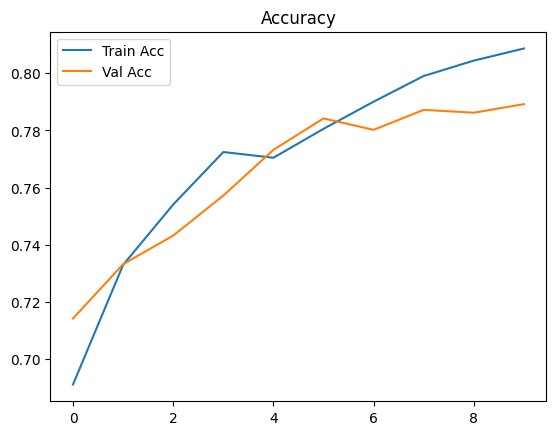

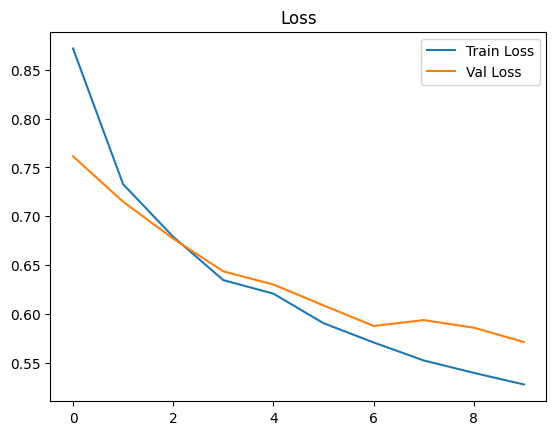

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

### Model Evaluation on Test Set

This code evaluates the model's performance on the test dataset, returning the final test loss and test accuracy.

In [8]:
model.evaluate(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.7853 - loss: 0.5778


[0.5629299283027649, 0.7974051833152771]

### Displaying Class Names

This code prints the list of class names (labels) present in the training dataset, which represent the 7 types of skin diseases in the HAM10000 dataset.

In [9]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


### Making a Single Image Prediction

This function takes a model, image path, and class names to predict the skin disease class of a single image. It resizes the image, processes it into a batch, makes a prediction, and prints the predicted class along with its confidence score.

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_simple(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Make batch

    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    print(f"Prediction: {predicted_class} ({confidence*100:.2f}% confidence)")

### Predicting a Test Image

This code uses the trained model to predict the class of a specific test image (ISIC_0027522.jpg) and prints the predicted skin disease label along with the confidence percentage.

In [29]:
img_path = "/kaggle/working/ham10000_data/test/vasc/ISIC_0027522.jpg"
predict_image_simple(model, img_path, train_ds.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: vasc (99.33% confidence)


### Predicting and Displaying Image with Diagnosis

This function loads an image, makes a prediction using the trained model, and displays the image with the predicted skin disease name and confidence level. It also maps the class code (e.g., nv) to a full disease name for better readability.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Optional: Mapping short names to full disease names
disease_full_names = {
    'akiec': 'Actinic Keratoses (Pre-cancer)',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis-like Lesion',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma (Skin Cancer)',
    'nv': 'Melanocytic Nevus (Mole)',
    'vasc': 'Vascular Lesion'
}

def predict_and_show(model, img_path, class_names):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Batch

    # Predict
    preds = model.predict(img_array)
    class_index = np.argmax(preds)
    predicted_class = class_names[class_index]
    confidence = np.max(preds)

    # Get full name (optional)
    full_name = disease_full_names.get(predicted_class, predicted_class)

    # Show image with prediction
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"{full_name}\n({confidence*100:.2f}% confidence)", fontsize=12)
    plt.show()

    print(f"Predicted class: {predicted_class} ({confidence*100:.2f}% confidence)")

### Displaying Prediction for a Specific Image

This code uses the predict_and_show function to predict and visualize the skin disease for a specific test image (ISIC_0027522.jpg) along with its disease name and confidence score.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


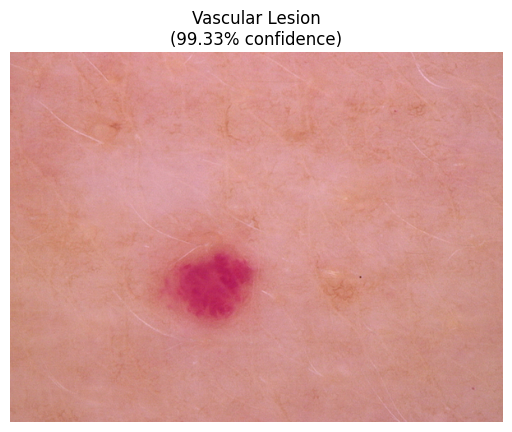

Predicted class: vasc (99.33% confidence)


In [31]:
img_path = "/kaggle/working/ham10000_data/test/vasc/ISIC_0027522.jpg"
predict_and_show(model, img_path, train_ds.class_names)

# Conclusion

In this project, we successfully built a deep learning model to classify different types of skin diseases using the HAM10000 dataset and the EfficientNetB0 architecture. The dataset was organized into training, validation, and test sets, and all images were resized to 224x224 pixels to match the input requirements of the model.

The model training and evaluation results were as follows:

1. Training Accuracy: 81.08%
2. Training Loss: 0.5295
3. Validation Accuracy: 78.92%
4. Validation Loss: 0.5714
5. Test Accuracy: 79.74%
6. Test Loss: 0.5629

These performance metrics reflect the model’s strong ability to generalize across unseen data. The use of EfficientNetB0 helped maintain a balance between efficiency and accuracy, making it a suitable choice for medical image classification tasks where both performance and speed are critical.